In [47]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,Adadelta,Adagrad,RMSprop,Adamax,SGD
#尝试了这么多优化器还是Adam比较好
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import math
import math
from sklearn.utils import class_weight

In [27]:
train = pd.read_csv('data/sensor_train.csv')
test = pd.read_csv('data/sensor_test.csv')
sub = pd.read_csv('提交结果示例.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [28]:
train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5

In [29]:
#角度特征
def arccos(x):
    return math.acos(x)

for x in ['acc_xg', 'acc_yg', 'acc_zg']:
    #train['acos_'+x] =  train.apply(lambda row: (math.pi-arccos(-row[x]/row['modg']))*180, axis=1)
    train['acos_'+x] =  train.apply(lambda row: arccos(row[x]/row['modg']) , axis=1)

for x in ['acc_xg', 'acc_yg', 'acc_zg']:
    #test['acos_'+x]=  test.apply(lambda row: (math.pi-arccos(-row[x]/row['modg']))*180, axis=1)
    test['acos_'+x]=  test.apply(lambda row: arccos(row[x]/row['modg']) , axis=1)
    


In [30]:
 #加入角度特征都可以在0.75以上，不管是余弦值还是角度

In [31]:
data = pd.concat([train , test], sort=False) #默认拼接到下面axis=0

In [32]:
data.head()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id,mod,modg,acos_acc_xg,acos_acc_yg,acos_acc_zg
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0.0,0.435890,9.902020,1.510165,1.099039,0.476278
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0.0,0.412311,9.633795,1.529264,1.061153,0.511665
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0.0,0.316228,10.147413,1.481987,1.100313,0.480150
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0.0,0.519615,8.635392,1.478021,0.995276,0.584881
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0.0,0.640312,10.104949,1.481613,1.087028,0.493339


In [33]:
# 使用训练集和测试集的数据一起进行标准化
def feature_normalize(x,i):
    mu = np.mean(data[i], axis=0)
    sigma = np.std(data[i], axis=0)
    return (x - mu) / sigma
for i in [x for x in train.columns if x not in ['behavior_id','fragment_id','time_point']]:
    train[i] = feature_normalize(train[i],i)
for i in [x for x in test.columns if x not in ['behavior_id','fragment_id','time_point']]:
    test[i] = feature_normalize(test[i],i)

# 2d数据

In [54]:
sample_len = 60
# 60 0.708
# 70 0.715  其中一个0.72
# 
x = np.zeros((7292, sample_len, 8))  #60,70
t = np.zeros((7500, sample_len, 8))
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_len]
    x[i,:,:] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_len]
    t[i,:,:] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 548.75it/s]


# 3d数据

In [34]:
sample_len = 60
featrue_num = 11
# 60 0.708
# 70 0.715  其中一个0.72
# 
x = np.zeros((7292, sample_len, featrue_num, 1))  #60,70
t = np.zeros((7500, sample_len, featrue_num, 1))
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_len]
    x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_len]
    t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 554.75it/s]


In [ ]:
# 之前是先标准化再采样，
# 这里是先采样再标准化
# 标准化
for i in tqdm(range(11)):
    mean_s = np.mean(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    sd_s = np.std(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    x[:,:,i,0] = (x[:,:,i,0]-mean_s)/sd_s

for i in tqdm(range(11)):
    mean_s = np.mean(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    sd_s = np.std(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    t[:,:,i,0] = (t[:,:,i,0]-mean_s)/sd_s

# MLP

In [72]:
def Net():
    input = Input(shape=(60, 8)) #使用多通道
    X = Dense(64, activation='relu')(input)
    X = Dense(128, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(512, activation='relu')(X)
    X = Dense(512, activation='relu')(X)
    X = Flatten()(X)
    X = Dropout(0.3)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)


# lstm

In [82]:


#model = Sequential()
def Net():
    input = Input(shape =(60,8))
    layer = LSTM(256, return_sequences=True)(input)
   # layer = GRU(256, return_sequences=True)(input)
    
    #layer = LSTM(512, return_sequences=True)(layer)
    layer = LSTM(256)(layer)
   
    layer = Dropout(0.5)(layer)
    X = Dense(19, activation='softmax')(layer)
    return Model([input], X)

In [50]:

def Net():
    input = Input(shape=(60, featrue_num, 1)) #使用多通道
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = GlobalMaxPooling2D()(X)
    X = Dropout(0.3)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)

# 0.75
"""
def Net():
    input = Input(shape=(60, 8, 1)) #使用多通道
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = GlobalMaxPooling2D()(X)
    X = Dropout(0.3)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)
"""
# 把GlobalMaxPooling2D 变成MaxPooling2D0.724
#best   使用全局标准化0.74 - 0.76

"""
def Net():
    input = Input(shape=(sample_len, featrue_num, 1))
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Dropout(0.5)(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    #X = GlobalMaxPooling2D()(X)
    print(X.shape)
    X = Permute((1,3,2))(X)#35, 4, 512
    X = MaxPooling2D(pool_size=(3,7))(X)
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)
"""

"\ndef Net():\n    input = Input(shape=(sample_len, featrue_num, 1))\n    X = Conv2D(filters=64,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(input)\n    X = Conv2D(filters=128,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    X = MaxPooling2D()(X)\n    X = Dropout(0.5)(X)\n    X = Conv2D(filters=256,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    X = Conv2D(filters=512,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    #X = GlobalMaxPooling2D()(X)\n    print(X.shape)\n    X = Permute((1,3,2))(X)#35, 4, 512\n    X = MaxPooling2D(pool_size=(3,7))(X)\n    X = Flatten()(X)\n    X = Dropout(0.5)(X)\n    X = Dense(19, activation='softmax')(X)\n    return Model([input], X)\n"

# Resnte

In [ ]:
def ResNet():
    main_input = Input(shape=(60, 6))
    x = K.expand_dims(main_input, -1)  #扩展为
    x = Conv2D(filters=32, kernel_size=[7,1], strides=(2,1),padding="same",data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name="relu")(x)
    x = block1(x,32,kernel_size=[5,1],srides=(1,2),repeat=1)
    
    x1 = block2(x,out_channels,kernel_size=[2,1],srides=(2,1),repeat=3)
    x2 = block2(x,out_channels,kernel_size=[3,1],srides=(2,1),repeat=3)
    x3 = block2(x,out_channels,kernel_size=[5,1],srides=(2,1),repeat=3)
    x1 = Reshape((x.shape[0],-1))(x1)
    x2 = Reshape((x.shape[0],-1))(x2)
    x3 = Reshape((x.shape[0],-1))(x3)
    x1 = block3(x1,256,kernel_size=2,srides=2,repeat=3)
    x2 = block3(x2,256,kernel_size=3,srides=2,repeat=3)
    x3 = block3(x3,256,kernel_size=5,srides=2,repeat=3)
    
    x1 = adapmaxpooling(x1,x1.shape[-1])
    x2 = adapmaxpooling(x2,x2.shape[-1])
    x3 = adapmaxpooling(x3,x3.shape[-1])
    x4 = Concatenate()([x1,x2,x3])
    
    model = Dense(19)(x4)
    model = BatchNormalization()(model)
    output = Activation('softmax', name="softmax")(model)
    model = Model(inputs=main_input, outputs=output)
    model.summary()  # 但因模型的
    return model

# 打印模型

In [51]:
model = Net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 512)               0         
__________

In [52]:
kfold = StratifiedKFold(5, shuffle=True,random_state=0)
#random_state 0 0.724   1994
# 2020

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_12 (Glo (None, 512)               0         
__________

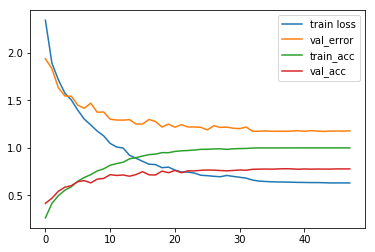

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_13 (Glo (None, 512)               0         
__________

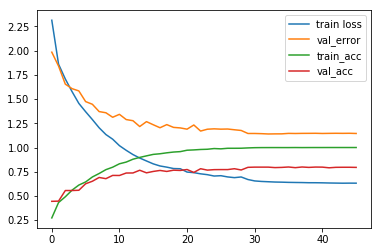

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_14 (Glo (None, 512)               0         
__________

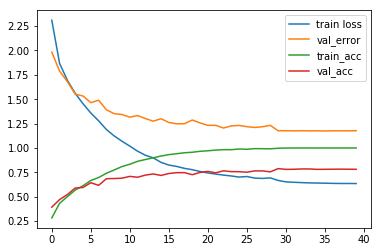

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_15 (Glo (None, 512)               0         
__________

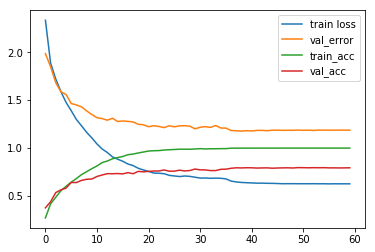

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 60, 11, 1)         0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 60, 11, 64)        640       
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 30, 5, 128)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 30, 5, 256)        295168    
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 30, 5, 512)        1180160   
_________________________________________________________________
global_max_pooling2d_16 (Glo (None, 512)               0         
__________

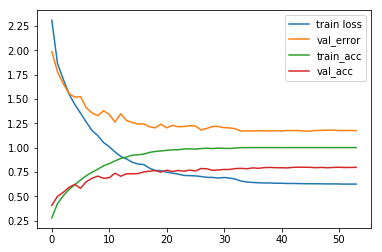

In [55]:
proba_t = np.zeros((7500, 19))
#标签平滑
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])

    # returned the smoothed labels
    return labels
#y_ = to_categorical(y, num_classes=19)

for fold, (xx, yy) in enumerate(kfold.split(x, y)):
    y_ = to_categorical(y, num_classes=19)
    y_ = smooth_labels(y_,factor=0.1)
    model = Net()
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),#Adadelta
                  metrics=['acc'])
    plateau = ReduceLROnPlateau(monitor="val_acc",#val_loss
                                verbose=0,
                                mode='max',#‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
                                factor=0.1,#lr = lr*factor的形式被减少  0.1和0.02都可以
                                patience=6)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=0,
                                   mode='max',
                                   patience=10)
    checkpoint = ModelCheckpoint('fold'+str(fold)+'.h5',
                                 monitor='val_acc',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    my_class_weight = class_weight.compute_class_weight('balanced'
                                          ,np.unique(np.argmax(y_[xx],axis=-1))
                                          ,np.argmax(y_[xx],axis=-1)).tolist()
    
    # 需要转成字典
    class_weight_dict = dict(zip([x for x in np.unique(np.argmax(y_[xx],axis=-1))], my_class_weight))
    #class_weight=class_weight_dict
    history = model.fit(x[xx], y_[xx],
              epochs=100,
              batch_size=32,#128,256,512,更小的64 0.724
              verbose=2,
              shuffle=True,
              validation_data=(x[yy], y_[yy]),
              callbacks=[plateau, early_stopping, checkpoint],
                        class_weight=class_weight_dict)
    y_true = np.argmax(y_[yy],axis=-1)

    y_pred = np.argmax(model.predict(x[yy], verbose=0, batch_size=1024),axis=-1)
    print("classification report:\n")
    print(classification_report(y_true, y_pred))
    model.load_weights('fold'+str(fold)+'.h5')
    proba_t += model.predict(t, verbose=0, batch_size=1024) / 5.
    plt.plot(history.epoch, history.history['loss'], label='train loss')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.plot(history.epoch, history.history['acc'],label='train_acc')
    plt.plot(history.epoch, history.history['val_acc'], label = 'val_acc')
    plt.legend()
    plt.show()
    


In [56]:
sub.behavior_id = np.argmax(proba_t, axis=1)
sub.to_csv('提交结果示例.csv', index=False)
#0.72 0.72 0.71 0.68

In [ ]:
 precision    recall  f1-score   support

           0       0.80      0.83      0.82        48
           1       0.76      0.76      0.76       135
           2       0.78      0.84      0.81        82
           3       0.79      0.66      0.72        67
           4       0.85      0.89      0.87        87
           5       0.77      0.74      0.76        69
           6       0.70      0.81      0.75       149
           7       0.85      0.62      0.72        47
           8       0.75      0.73      0.74        66
           9       0.76      0.59      0.66        58
          10       0.53      0.72      0.61        47
          11       0.82      0.80      0.81        90
          12       0.82      0.85      0.83       147
          13       0.61      0.62      0.62        58
          14       0.81      0.52      0.63        25
          15       0.74      0.75      0.75        96
          16       0.89      0.94      0.92        69
          17       0.79      0.65      0.72        52
          18       0.86      0.83      0.84        69

   micro avg       0.77      0.77      0.77      1461
   macro avg       0.77      0.74      0.75      1461
weighted avg       0.77      0.77      0.77      1461


precision    recall  f1-score   support

           0       0.67      0.69      0.68        48
           1       0.69      0.70      0.70       135
           2       0.84      0.76      0.79        82
           3       0.76      0.77      0.77        66
           4       0.85      0.91      0.88        87
           5       0.81      0.75      0.78        69
           6       0.64      0.74      0.69       148
           7       0.76      0.60      0.67        47
           8       0.77      0.82      0.79        66
           9       0.65      0.60      0.62        57
          10       0.76      0.66      0.70        47
          11       0.82      0.77      0.79        90
          12       0.76      0.88      0.82       147
          13       0.72      0.62      0.67        58
          14       0.67      0.56      0.61        25
          15       0.73      0.74      0.74        96
          16       0.88      0.99      0.93        69
          17       0.80      0.69      0.74        52
          18       0.84      0.74      0.78        69

   micro avg       0.76      0.76      0.76      1458
   macro avg       0.76      0.74      0.74      1458
weighted avg       0.76      0.76      0.75      1458


 precision    recall  f1-score   support

           0       0.74      0.77      0.76        48
           1       0.74      0.71      0.72       135
           2       0.80      0.78      0.79        82
           3       0.75      0.71      0.73        66
           4       0.86      0.92      0.89        87
           5       0.74      0.72      0.73        69
           6       0.66      0.76      0.71       148
           7       0.73      0.64      0.68        47
           8       0.79      0.80      0.80        66
           9       0.70      0.54      0.61        57
          10       0.68      0.64      0.66        47
          11       0.79      0.78      0.78        90
          12       0.79      0.91      0.85       147
          13       0.74      0.64      0.69        58
          14       0.78      0.56      0.65        25
          15       0.75      0.73      0.74        96
          16       0.93      0.97      0.95        69
          17       0.80      0.75      0.77        52
          18       0.85      0.80      0.82        69

   micro avg       0.77      0.77      0.77      1458
   macro avg       0.77      0.74      0.75      1458
weighted avg       0.77      0.77      0.76      1458



precision    recall  f1-score   support

           0       0.63      0.92      0.75        48
           1       0.82      0.83      0.83       135
           2       0.89      0.80      0.84        81
           3       0.87      0.80      0.83        66
           4       0.88      0.89      0.88        87
           5       0.82      0.72      0.77        68
           6       0.74      0.72      0.73       148
           7       0.76      0.74      0.75        47
           8       0.77      0.83      0.80        65
           9       0.58      0.53      0.55        57
          10       0.65      0.68      0.67        47
          11       0.84      0.80      0.82        89
          12       0.81      0.92      0.86       146
          13       0.83      0.67      0.74        58
          14       0.85      0.92      0.88        25
          15       0.80      0.71      0.75        95
          16       0.84      0.93      0.88        69
          17       0.80      0.73      0.76        51
          18       0.90      0.90      0.90        69

   micro avg       0.80      0.80      0.80      1451
   macro avg       0.79      0.79      0.79      1451
weighted avg       0.80      0.80      0.80      1451



